# Ideas
- Since some dimensions in PCA might care more about X dimension than Y dimension in position, maybe see if decoding on X and Y pos seperately has some effect.
    - Mainly to see whether there could be some dimension that is more informative in either

# FIX THE PREDICTION
- Ensure that the input to X has shape (T, N) and the Y has shape (T, K) where
    - T = Timepoints
    - N = Features
    - K = N_outputs

# Plan
- Decode firing rates on pos x and pos y seperately.
- Do some more research on the dimensionalities of X and y in decoding.
- For decoding only X position, use T\*N\*K for y and T\*N\*F for X.
    - Flatten pos[x], don't flatten or concat the firing rates. Only concat per trial.


In [1]:
from tqdm.notebook import tqdm
from df_processing import setup_df

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

#For firing rate calculation
import scipy.signal as scs
import scipy.ndimage

In [3]:
prior = 50
post = 300
bin_size = 0.01
removal_threshold = 5
maximum_duration_in_ms = 1000
movement_onset_treshold = 250
n_components = 10
main_df, firing_rates_per_session, pos_per_session, vel_per_session, projections_per_session = setup_df(prior,
                                                                                                        post, 
                                                                                                        bin_size, 
                                                                                                        removal_threshold, 
                                                                                                        movement_onset_treshold,
                                                                                                        maximum_duration_in_ms, 
                                                                                                        n_components, 
                                                                                                        debug=True)

Creating base...
Deleting NaNs...
Removing trials which take longer than 1000ms ...
Square root Stabilizing spiking rates...
Centering session positions...
Calculating acceleration...
Determining movement onset...
Removing low firing neural below 5Hz...
Updating bin size to 0.01...
Calculating firing rate...
Calculating firing rates in window from movement onset to 300ms...
Calculating positions in window from movement onset to 300ms...
Calculating velocity in window from movement onset to 300ms...
Calculating 10 PC's.
Done!


In [168]:
def predict_both_pos(data_df, 
                     model = Ridge(), 
                     iterations:int = 1, 
                     prior: int = 0, 
                     post: int = 0, 
                     col_to_use:str = 'firing_rates_window', 
                     col_to_predict:str = 'pos_window', 
                     cols_to_decode: list = [],
                     time_offset: int = 0,
                     debug = False,
                     sliding_window = 0):
    """

    Args:
        - time_offset (int):
            The amount of bins the decoding data should lag behind the predicted data.
            Example: if time_offset == 50, the firing rates used to decode are the ones found 50ms after actual movements are made.
    Returns:

    
    
    """

    df = data_df.copy()
    scores = []
    filtered_df = df.dropna(subset=['pos_window'])
    testing_trial = filtered_df.iloc[0]
    
    


    for sesh in [0,1,2,3]:
        session_data = df[(df['session'] == sesh) & (df['result'] == 'R')].copy().reset_index(drop=True)
        session_prior = prior
        session_post = post


        #Since each window starts from (movement onset - prior), we have to do some calculating to determine start of window.
        if post == 0:
            session_post = session_data.iloc[0]['pos_window'].shape[0]

        if prior == 0:
            if session_data.iloc[0]['prior'] != 0:
                session_prior = session_data.iloc[0]['prior']
                session_post += prior
            else:
                prior = 0
        else:
            session_prior = int(session_data.iloc[0]['prior'] - prior)
            session_post += session_data.iloc[0]['prior']
        
        #Ensure prior is positive.
        assert(prior >= 0), "Prior given is larger than the prior given during Dataframe Creation."
        if debug:
            print(f"post: {session_post}. Offset:{ time_offset}. Len of windows: {session_data.iloc[0]['pos_window'].shape[0]}")
        assert (session_post + time_offset <= session_data.iloc[0]['pos_window'].shape[0]), "The range of post + offset is larger than the window calculated. Increase the post value on the dataframe."

    

        if len(session_data) < 10:
            continue
        session_data = session_data.iloc[:-2]
        
        #For sliding window, add a start_location modifier.
        if sliding_window > 0:
            session_prior = int(session_post - sliding_window)
            if debug:
                print(f'Taking sliding window from {session_prior} to {session_post}')
        

        if cols_to_decode == []:
            length = session_data.iloc[0][col_to_use].shape[1]
            decoding_col = list(range(length))
        else:
            decoding_col = cols_to_decode
        
        val_to_predict = [x[col_to_use][session_prior+time_offset:session_post+time_offset,decoding_col] for _, x in session_data.iterrows()]

        X = np.array(val_to_predict)
        X = np.reshape(X, (X.shape[0]*X.shape[1], X.shape[2]))
        if debug:
            print(f'Shape of X: Trials: {len(val_to_predict)}. T*N: {val_to_predict[0].shape}. After reshaping: {X.shape}')

        pred_x = np.array([x[col_to_predict][session_prior:session_post, 0] for _, x in session_data.iterrows()])
        pred_y = np.array([x[col_to_predict][session_prior:session_post, 1] for _, x in session_data.iterrows()])
        
        xy = np.reshape(pred_x, (pred_x.shape[0]*pred_x.shape[1],))
        yy = np.reshape(pred_y, (pred_y.shape[0]*pred_y.shape[1],))
        if debug:
            print(f'Shape of the x and y coordinate lists: {pred_x.shape, pred_y.shape}')
            print(f'After reshaping: Shape of y vectors: {yy.shape}\n')
        session_scores = []
        for x in range(iterations):
            XX_train, XX_test, xy_train, xy_test = train_test_split(X, xy)
            YX_train, YX_test, yy_train, yy_test = train_test_split(X, yy)

            xmodel = model
            xmodel.fit(XX_train, xy_train)
            xpredictions = xmodel.predict(XX_test)

            ymodel = model
            ymodel.fit(YX_train, yy_train)
            ypredictions = ymodel.predict(YX_test)
            
            pred = list(zip(xpredictions, ypredictions))
            y_true = list(zip(xy_test, yy_test))

            r2 = r2_score(y_true, pred)
            session_scores.append(r2)
        scores.append([np.mean(np.array(session_scores)), session_scores])
    return scores
        

predict_both_pos(main_df, prior=0, post=100, debug=True)

post: 100. Offset:0. Len of windows: 350
Shape of X: Trials: 538. T*N: (50, 39). After reshaping: (26900, 39)
Shape of the x and y coordinate lists: ((538, 50), (538, 50))
After reshaping: Shape of y vectors: (26900,)

post: 100. Offset:0. Len of windows: 350
Shape of X: Trials: 1277. T*N: (50, 30). After reshaping: (63850, 30)
Shape of the x and y coordinate lists: ((1277, 50), (1277, 50))
After reshaping: Shape of y vectors: (63850,)

post: 100. Offset:0. Len of windows: 350
Shape of X: Trials: 480. T*N: (50, 87). After reshaping: (24000, 87)
Shape of the x and y coordinate lists: ((480, 50), (480, 50))
After reshaping: Shape of y vectors: (24000,)

post: 100. Offset:0. Len of windows: 350
Shape of X: Trials: 462. T*N: (50, 85). After reshaping: (23100, 85)
Shape of the x and y coordinate lists: ((462, 50), (462, 50))
After reshaping: Shape of y vectors: (23100,)



[[0.08613068845178867, [0.08613068845178867]],
 [0.3142927225733434, [0.3142927225733434]],
 [0.8134694390751058, [0.8134694390751058]],
 [0.8003798093538131, [0.8003798093538131]]]

  0%|          | 0/21 [00:00<?, ?it/s]

Prior updated
50 150
50 150
50 150
50 150
Prior updated
50 160
50 160
50 160
50 160
Prior updated
50 170
50 170
50 170
50 170
Prior updated
50 180
50 180
50 180
50 180
Prior updated
50 190
50 190
50 190
50 190
Prior updated
50 200
50 200
50 200
50 200
Prior updated
50 210
50 210
50 210
50 210
Prior updated
50 220
50 220
50 220
50 220
Prior updated
50 230
50 230
50 230
50 230
Prior updated
50 240
50 240
50 240
50 240
Prior updated
50 250
50 250
50 250
50 250
Prior updated
50 260
50 260
50 260
50 260
Prior updated
50 270
50 270
50 270
50 270
Prior updated
50 280
50 280
50 280
50 280
Prior updated
50 290
50 290
50 290
50 290
Prior updated
50 300
50 300
50 300
50 300
Prior updated
50 310
50 310
50 310
50 310
Prior updated
50 320
50 320
50 320
50 320
Prior updated
50 330
50 330
50 330
50 330
Prior updated
50 340
50 340
50 340
50 340
Prior updated
50 350
50 350
50 350
50 350


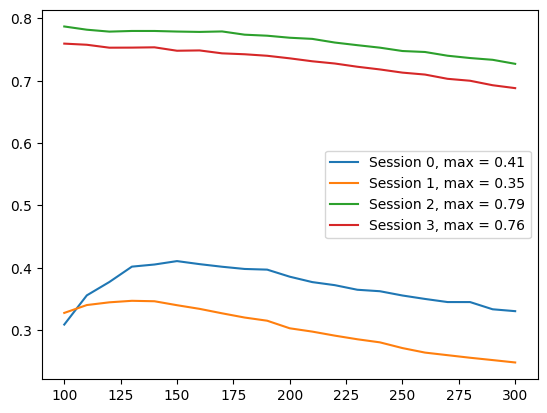

In [17]:
posts = np.linspace(100, 300, 21).astype(int)

results = []
for post in tqdm(posts):
    results.append(predict_both_pos(main_df, iterations=3, post=post))

plt.plot(posts, [x[0][0] for x in results],  label=f'Session 0, max = {round(max([x[0][0] for x in results]), 2)}')
plt.plot(posts, [x[1][0] for x in results],  label=f'Session 1, max = {round(max([x[1][0] for x in results]), 2)}')
plt.plot(posts, [x[2][0] for x in results],  label=f'Session 2, max = {round(max([x[2][0] for x in results]), 2)}')
plt.plot(posts, [x[3][0] for x in results],  label=f'Session 3, max = {round(max([x[3][0] for x in results]), 2)}')
plt.legend()
plt.show()

In [55]:
main_df, _, _,_, _ = setup_df(    0,
                                1000, 
                                bin_size, 
                                removal_threshold, 
                                movement_onset_treshold,
                                maximum_duration_in_ms, 
                                n_components, 
                                debug=True)

Creating base...
Deleting NaNs...
Removing trials which take longer than 1000ms ...
Square root Stabilizing spiking rates...
Centering session positions...
Calculating acceleration...
Determining movement onset...
Removing low firing neural below 5Hz...
Updating bin size to 0.01...
Calculating firing rate...
Calculating firing rates in window from movement onset to 1000ms...
Calculating positions in window from movement onset to 1000ms...
Calculating velocity in window from movement onset to 1000ms...
Calculating 10 PC's.
Done!


[100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270
 280 290 300]


  0%|          | 0/21 [00:00<?, ?it/s]

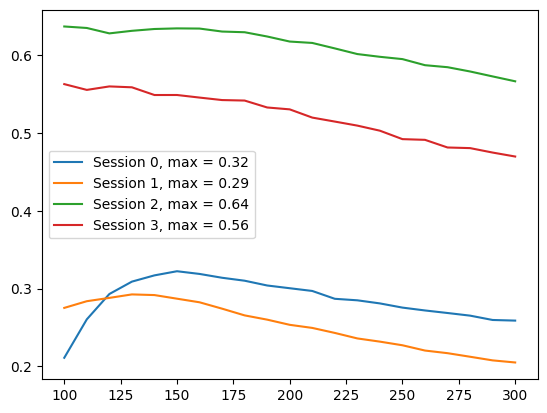

In [26]:
posts = np.linspace(100, 300, 21).astype(int)
print(posts)

results = []
for post in tqdm(posts):
    results.append(predict_both_pos(main_df, iterations=3, post=post, col_to_use='PCA_window_from_full'))

plt.plot(posts, [x[0][0] for x in results],  label=f'Session 0, max = {round(max([x[0][0] for x in results]), 2)}')
plt.plot(posts, [x[1][0] for x in results],  label=f'Session 1, max = {round(max([x[1][0] for x in results]), 2)}')
plt.plot(posts, [x[2][0] for x in results],  label=f'Session 2, max = {round(max([x[2][0] for x in results]), 2)}')
plt.plot(posts, [x[3][0] for x in results],  label=f'Session 3, max = {round(max([x[3][0] for x in results]), 2)}')
plt.legend()
plt.show()

# Testing which projections are good and which aren't.

In [7]:
post = 200
from itertools import combinations
all_combos = []
for r in range(1, 11):
    for combo in combinations(range(10), r):
        all_combos.append(sorted(combo))
results = []
for projections in tqdm(all_combos):
    results.append(predict_both_pos(main_df, iterations=3, post=post, col_to_use='PCA_window_from_full', col_to_decode=projections))


  0%|          | 0/1023 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Plotting projection scores for each session

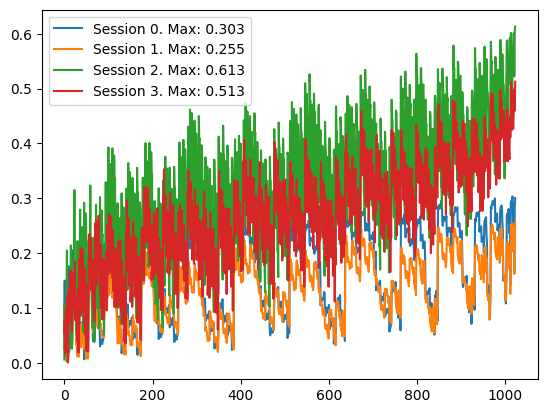

In [ ]:
session0=[x[0][0] for x in results]
session1=[x[1][0] for x in results]
session2=[x[2][0] for x in results]
session3=[x[3][0] for x in results]
s = [session0, session1, session2, session3]
for i, sesh in enumerate(s):
    plt.plot(sesh, label=f'Session {i}. Max: {round(max(sesh), 3)}')
plt.legend()
plt.show()

# With a window longer than 540 ms, smth goes wrong. Investigation below

In [27]:
post = 800
df = main_df.copy()
col_to_use = 'firing_rates_window'
for sesh in [0,1]:
    session_data = df[(df['session'] == sesh) & (df['result']=='R')].copy().reset_index()
    print(len(session_data))
    session_data = session_data.iloc[:-1]
    for i, x in session_data.iterrows():
        val_to_predict = x[col_to_use][:post, ]
        pos_x = x['pos_window'][:post, 0]
        print(i)
    val_to_predict = [x[col_to_use][:post,] for _, x in session_data.iterrows()]
    pos_x = np.array([x['pos_window'][:post, 0] for _, x in session_data.iterrows()])
    print(pos_x.shape)
#predict_both_pos(main_df, iterations=3, post=post, col_to_predict='PCA_window_from_full')

540
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

# Turns out the copying of the DF after filtering for session and reward wasn't correct. Also, the final trial wasn't long enough, so removed.

In [28]:
posts = np.linspace(10, 900, 81).astype(int)
print(posts)

results = []
for x in tqdm(posts):
    results.append(predict_both_pos(main_df, iterations=1, post=x, col_to_use='PCA_window_from_full'))


[ 10  21  32  43  54  65  76  87  99 110 121 132 143 154 165 176 188 199
 210 221 232 243 254 265 277 288 299 310 321 332 343 354 366 377 388 399
 410 421 432 443 455 466 477 488 499 510 521 532 544 555 566 577 588 599
 610 621 633 644 655 666 677 688 699 710 722 733 744 755 766 777 788 799
 811 822 833 844 855 866 877 888 900]


  0%|          | 0/81 [00:00<?, ?it/s]

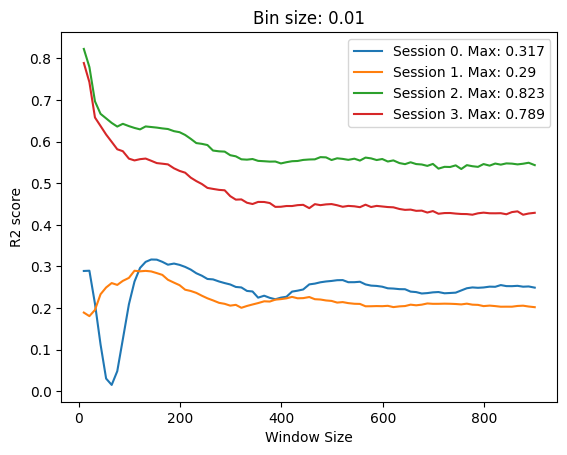

In [29]:
session0=[x[0][0] for x in results]
session1=[x[1][0] for x in results]
session2=[x[2][0] for x in results]
session3=[x[3][0] for x in results]
s = [session0, session1, session2, session3]
for i, sesh in enumerate(s):
    plt.plot(posts, sesh, label=f'Session {i}. Max: {round(max(sesh), 3)}')
plt.legend()
plt.xlabel('Window Size')
plt.ylabel('R2 score')
plt.title("Bin size: 0.01")
plt.show()

# Decoding for shorter amounts seems to be better?
Lets see how it goes for active vs. passive.

In [73]:
active_df = main_df[np.isnan(main_df['bumpDir'])].copy().reset_index(drop=True)
passive_df = main_df[~np.isnan(main_df['bumpDir'])].copy().reset_index(drop=True)

pca_results = []
for df in [active_df, passive_df]:
    df_result = []
    for x in tqdm(posts):
        df_result.append(predict_both_pos(df, iterations=1, post=x, col_to_use='PCA_window_from_full'))
    pca_results.append(df_result)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

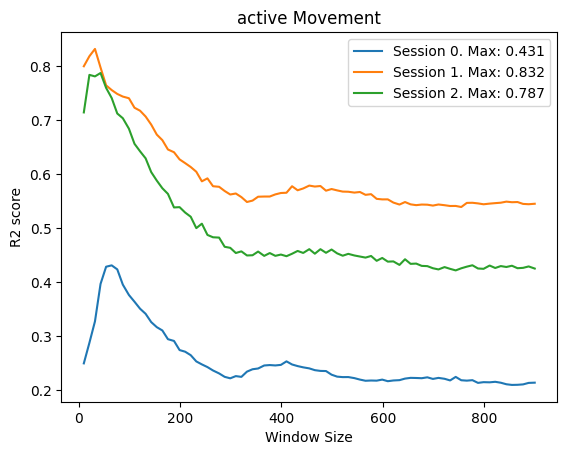

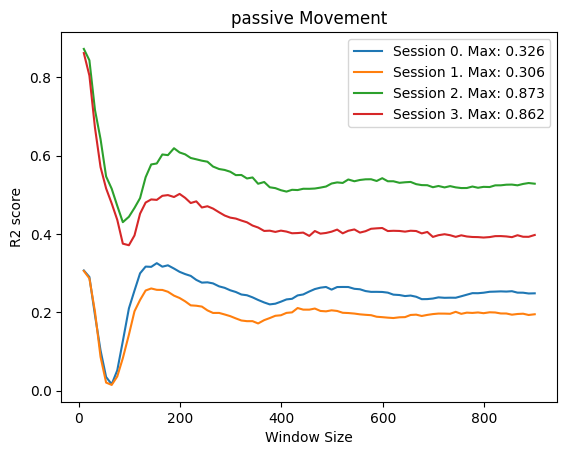

In [74]:
for i, results in enumerate(pca_results):
    s = []
    for k in range(len(results[0])):
        s.append([x[k][0] for x in results])
    for o, sesh in enumerate(s):
        plt.plot(posts, sesh, label=f'Session {o}. Max: {round(max(sesh), 3)}')
    plt.legend()
    plt.xlabel('Window Size')
    plt.ylabel('R2 score')
    if i == 0:
        j = 'active'
    else:
        j= 'passive'
    plt.title(f"{j} Movement")
    plt.show()


In [75]:
posts = np.linspace(10, 900, 81).astype(int)
active_df = main_df[np.isnan(main_df['bumpDir'])].copy().reset_index(drop=True)
passive_df = main_df[~np.isnan(main_df['bumpDir'])].copy().reset_index(drop=True)

fr_results = []
for df in [active_df, passive_df]:
    df_result = []
    for x in tqdm(posts):
        df_result.append(predict_both_pos(df, iterations=1, post=x, col_to_use='firing_rates_window'))
    fr_results.append(df_result)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

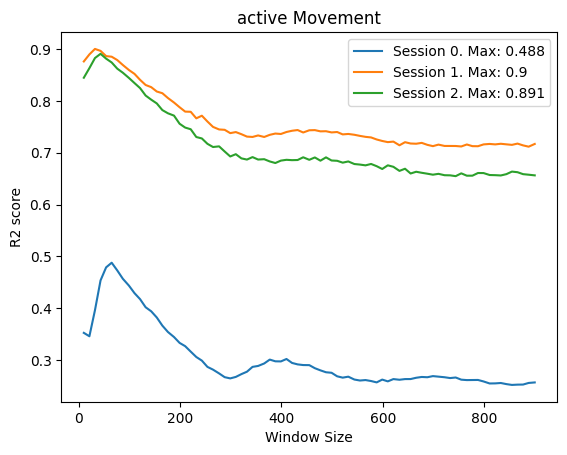

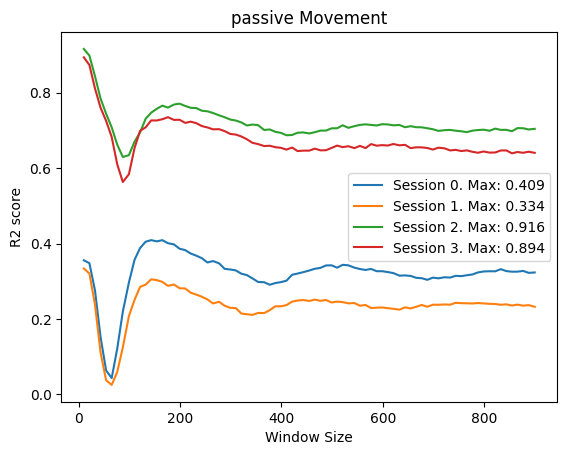

In [76]:
for i, results in enumerate(fr_results):
    s = []
    for k in range(len(results[0])):
        s.append([x[k][0] for x in results])
    for o, sesh in enumerate(s):
        plt.plot(posts, sesh, label=f'Session {o}. Max: {round(max(sesh), 3)}')
    plt.legend()
    plt.xlabel('Window Size')
    plt.ylabel('R2 score')
    if i == 0:
        j = 'active'
    else:
        j= 'passive'
    plt.title(f"{j} Movement")
    plt.show()


4


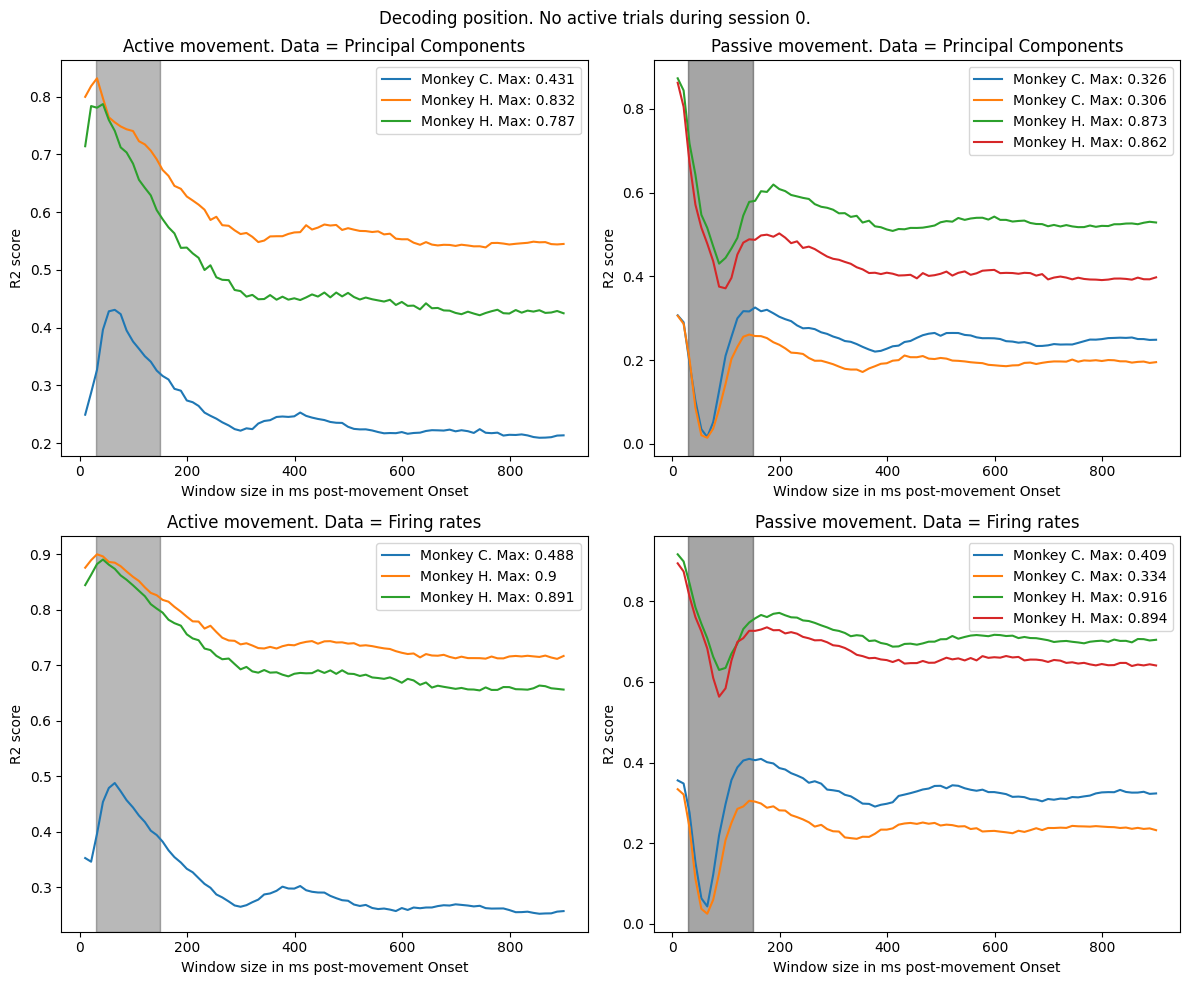

In [77]:
all_results = pca_results + fr_results
all_data = []
for i, run in enumerate(all_results):
    run_data = []
    for session in range(len(run[0])):
        session_data=[]
        for j, trial in enumerate(run):
            session_data.append(trial[session][0])
        run_data.append(session_data)
    all_data.append(run_data)
print(len(all_data))

fig, axs = plt.subplots(2, 2, figsize=((12, 10)))

for i, run in enumerate(all_data):
    for j, session in enumerate(run):
        row = i // 2
        col = i % 2
        if i % 2 == 0:
            monkey = 'C' if j < 1 else 'H'
            title = 'Active'
        else:
            title = 'Passive'
            monkey = 'C' if j < 2 else 'H'
        if i > 1:
            type_data = 'Firing rates'
        else:
            type_data = 'Principal Components'
        max_val = round(max(session), 3)
        axs[row, col].plot(posts, session, label=f'Monkey {monkey}. Max: {max_val}')
        axs[row, col].set_title(f"{title} movement. Data = {type_data}")
        axs[row, col].set_xlabel('Window size in ms post-movement Onset')
        axs[row, col].set_ylabel('R2 score')
        axs[row, col].axvspan(30, 150, color='black', alpha=0.1)
        axs[row, col].legend()

plt.suptitle("Decoding position. No active trials during session 0.")
plt.tight_layout()
plt.show()

                        


# Let's make a velocity window as well so we can decode on that.
This was very easy, using the pos_window generator code. Done

# I should also ensure that I can do pre-movement onset. Necessary for the window-offset.
Prior implementation is fixed. *Very important* to remember is that the window is calculated from [idx_movementOnset - prior: idx_movementOnset + post].<br>
We always have to keep into account that initial prior offset. This should be handled in the functions. <br>
To keep track of original window variables, new columns are created ['prior', 'post']

# Another thing to be added should be the offset-possibility


[ 10  21  32  43  54  65  76  87  99 110 121 132 143 154 165 176 188 199
 210 221 232 243 254 265 277 288 299 310 321 332 343 354 366 377 388 399
 410 421 432 443 455 466 477 488 499 510 521 532 544 555 566 577 588 599
 610 621 633 644 655 666 677 688 699 710 722 733 744 755 766 777 788 799
 811 822 833 844 855 866 877 888 900]


  0%|          | 0/81 [00:00<?, ?it/s]

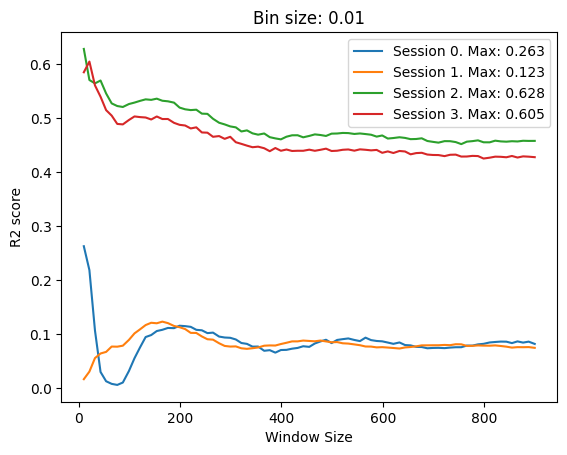

In [78]:
posts = np.linspace(10, 900, 81).astype(int)
print(posts)

results = []
for x in tqdm(posts):
    results.append(predict_both_pos(main_df, iterations=1, post=x, col_to_use='PCA_window_from_full', col_to_predict='vel_window'))
session0=[x[0][0] for x in results]
session1=[x[1][0] for x in results]
session2=[x[2][0] for x in results]
session3=[x[3][0] for x in results]
s = [session0, session1, session2, session3]
for i, sesh in enumerate(s):
    plt.plot(posts, sesh, label=f'Session {i}. Max: {round(max(sesh), 3)}')
plt.legend()
plt.xlabel('Window Size')
plt.ylabel('R2 score')
plt.title("Bin size: 0.01")
plt.show()

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

4


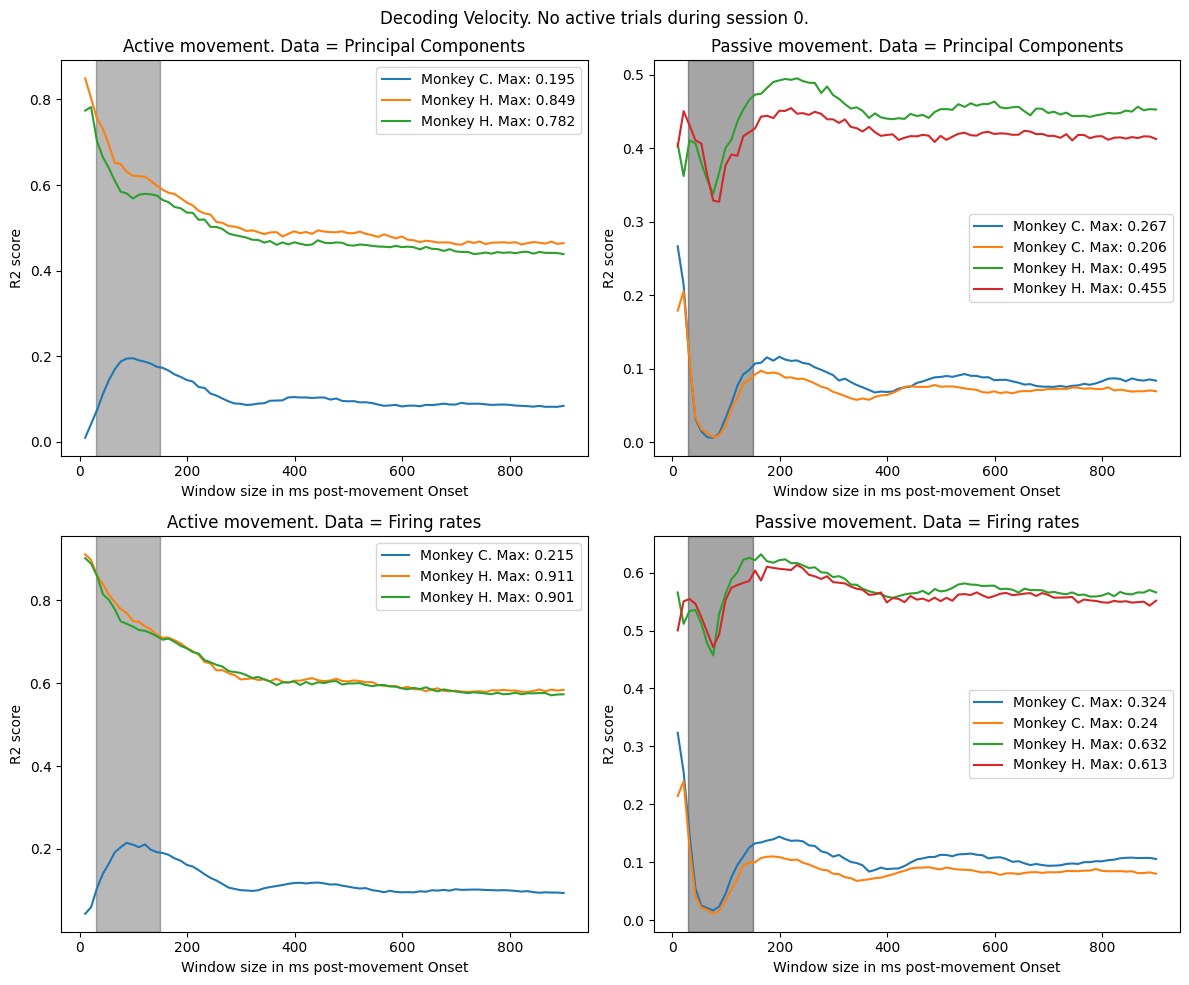

In [79]:
active_df = main_df[np.isnan(main_df['bumpDir'])].copy().reset_index(drop=True)
passive_df = main_df[~np.isnan(main_df['bumpDir'])].copy().reset_index(drop=True)

fr_results = []
for df in [active_df, passive_df]:
    df_result = []
    for x in tqdm(posts):
        df_result.append(predict_both_pos(df, iterations=1, post=x, col_to_use='firing_rates_window', col_to_predict='vel_window'))
    fr_results.append(df_result)

pca_results = []
for df in [active_df, passive_df]:
    df_result = []
    for x in tqdm(posts):
        df_result.append(predict_both_pos(df, iterations=1, post=x, col_to_use='PCA_window_from_full', col_to_predict='vel_window'))
    pca_results.append(df_result)

all_results = pca_results + fr_results
all_data = []
for i, run in enumerate(all_results):
    run_data = []
    for session in range(len(run[0])):
        session_data=[]
        for j, trial in enumerate(run):
            session_data.append(trial[session][0])
        run_data.append(session_data)
    all_data.append(run_data)
print(len(all_data))

fig, axs = plt.subplots(2, 2, figsize=((12, 10)))

for i, run in enumerate(all_data):
    for j, session in enumerate(run):
        row = i // 2
        col = i % 2
        if i % 2 == 0:
            monkey = 'C' if j < 1 else 'H'
            title = 'Active'
        else:
            title = 'Passive'
            monkey = 'C' if j < 2 else 'H'
        if i > 1:
            type_data = 'Firing rates'
        else:
            type_data = 'Principal Components'
        max_val = round(max(session), 3)
        axs[row, col].plot(posts, session, label=f'Monkey {monkey}. Max: {max_val}')
        axs[row, col].set_title(f"{title} movement. Data = {type_data}")
        axs[row, col].set_xlabel('Window size in ms post-movement Onset')
        axs[row, col].set_ylabel('R2 score')
        axs[row, col].axvspan(30, 150, color='black', alpha=0.1)
        axs[row, col].legend()

plt.suptitle("Decoding Velocity. No active trials during session 0.")
plt.tight_layout()
plt.show()

# Investigating offset parameter

In [180]:
offset_df, _, _, _, _ = setup_df(
    prior=50,
    post=1000,
    bin_size=0.01,
    removal_threshold=5,
    movement_onset_treshold=250,
    maximum_duration_in_ms=1000,
    n_components=30,
    debug=False,
)

In [249]:
posts = np.linspace(1, 90, 21).astype(int)
offsets = np.linspace(0, 10, 11).astype(int)

all_offset_data = []
for offset in tqdm(offsets):
    offset_data = []
    for post in tqdm(posts):
        test = predict_both_pos(data_df = offset_df,
                        model = Ridge(),
                        iterations = 3,
                        prior = 10,
                        post = post,
                        col_to_use = 'PCA_window_from_full',
                        col_to_predict = 'pos_window',
                        time_offset=offset,
                        debug=False
                        )
        res = [x[0] for x in test]
        offset_data.append(res)
    all_offset_data.append(offset_data)



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

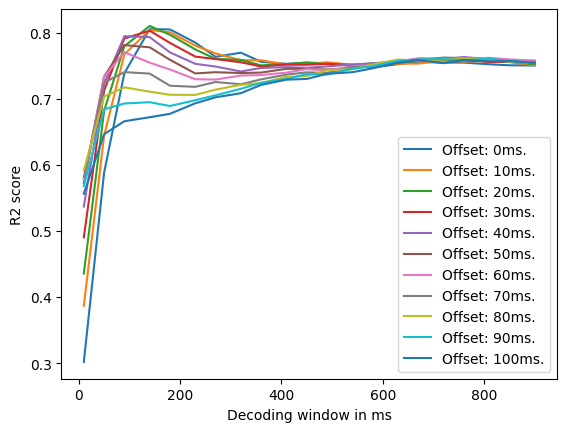

In [264]:
post_ms = posts * 10
for i, offset in enumerate(all_offset_data):
    session_data = []
    for j in [0,1,2,3]:
        session_data.append([x[j] for x in offset])
    plt.plot(post_ms, session_data[2], label=f'Offset: {offsets[i]*10}ms.')
plt.legend(loc='lower right')
plt.xlabel("Decoding window in ms")
plt.ylabel("R2 score")
plt.show()


# To do starting next week:

- Investigate the offset parameter further.
    - It appears an offset of 10 ms is ideal, but we should look at that difference in performance early on between 0ms and 20ms offsets.
    - Look at the offset parameter and it's effects on active/passive decoding.
<br>
- Perhaps try to make a decoder decoding active or passive (should be easy)
<br>
- As per Luke's suggestion:
    - Look at the data over time, through a 150ms sliding window. So determine decoding accuracy over, for example, 500ms of a trial, but in windows of 100ms. So, 100ms-200ms PMO (post movement onset), 110-210ms PMO etc etc.
        - Do this to determine what the effect of the bump is. Difference in r2 between active and passive trials should mostly happen during the bump, for the rest the decoding accuracy should be equal.

- Optionals: 
    - Optimize the PCA. Haven't worked on this yet, so could be worth looking into.
    - Try to decode with more PC's.
    - Investigate the impact of different principal components.
        - Check decoding efficiency on PC's in general. Also interesting in combination with the decoding window, are some PC's more useful during specific timepoints?


# Work on decoding a sliding window first

Expected outcome: Decoding accuracy differs for first ~200 ms for passive trials. After that, decoding should stabilize to the same efficiency as active trials.

In [24]:
A_offset_df = offset_df[np.isnan(offset_df['bumpDir'])].copy().reset_index(drop=True)
P_offset_df = offset_df[~np.isnan(offset_df['bumpDir'])].copy().reset_index(drop=True)

In [26]:
for session in [0,1,2,3]:
    Aamount = len(A_offset_df[(A_offset_df['session'] == session) & (A_offset_df['result'] == 'R')])
    Pamount = len(P_offset_df[(P_offset_df['session'] == session) & (P_offset_df['result'] == 'R')])
    print(f"For session {session}, the counts are: A = {Aamount}, P = {Pamount}.")

For session 0, the counts are: A = 1, P = 539.
For session 1, the counts are: A = 664, P = 615.
For session 2, the counts are: A = 255, P = 227.
For session 3, the counts are: A = 246, P = 218.


In [265]:
offset = 0
window_size = 100
start = 100
end = 900
amount = 35
windows = np.linspace(start, end, amount).astype(int)
print(windows)
both_results = []
for post in tqdm(windows):
    test = predict_both_pos(data_df = offset_df,
                            model = Ridge(),
                            iterations = 5,
                            prior = 50,
                            post = post,
                            col_to_use = 'PCA_window_from_full',
                            col_to_predict = 'pos_window',
                            time_offset=offset,
                            debug=False,
                            sliding_window = window_size
                            )
    both_results.append(test)
act_results = []
for post in tqdm(windows):
    test = predict_both_pos(data_df = A_offset_df,
                            model = Ridge(),
                            iterations = 5,
                            prior = 50,
                            post = post,
                            col_to_use = 'PCA_window_from_full',
                            col_to_predict = 'pos_window',
                            time_offset=offset,
                            debug=False,
                            sliding_window = window_size
                            )
    act_results.append(test)

pas_results = []
for post in tqdm(windows):
    test = predict_both_pos(data_df = P_offset_df,
                            model = Ridge(),
                            iterations = 5,
                            prior = 50,
                            post = post,
                            col_to_use = 'PCA_window_from_full',
                            col_to_predict = 'pos_window',
                            time_offset=offset,
                            debug=False,
                            sliding_window = window_size
                            )
    pas_results.append(test)

[100 123 147 170 194 217 241 264 288 311 335 358 382 405 429 452 476 500
 523 547 570 594 617 641 664 688 711 735 758 782 805 829 852 876 900]


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

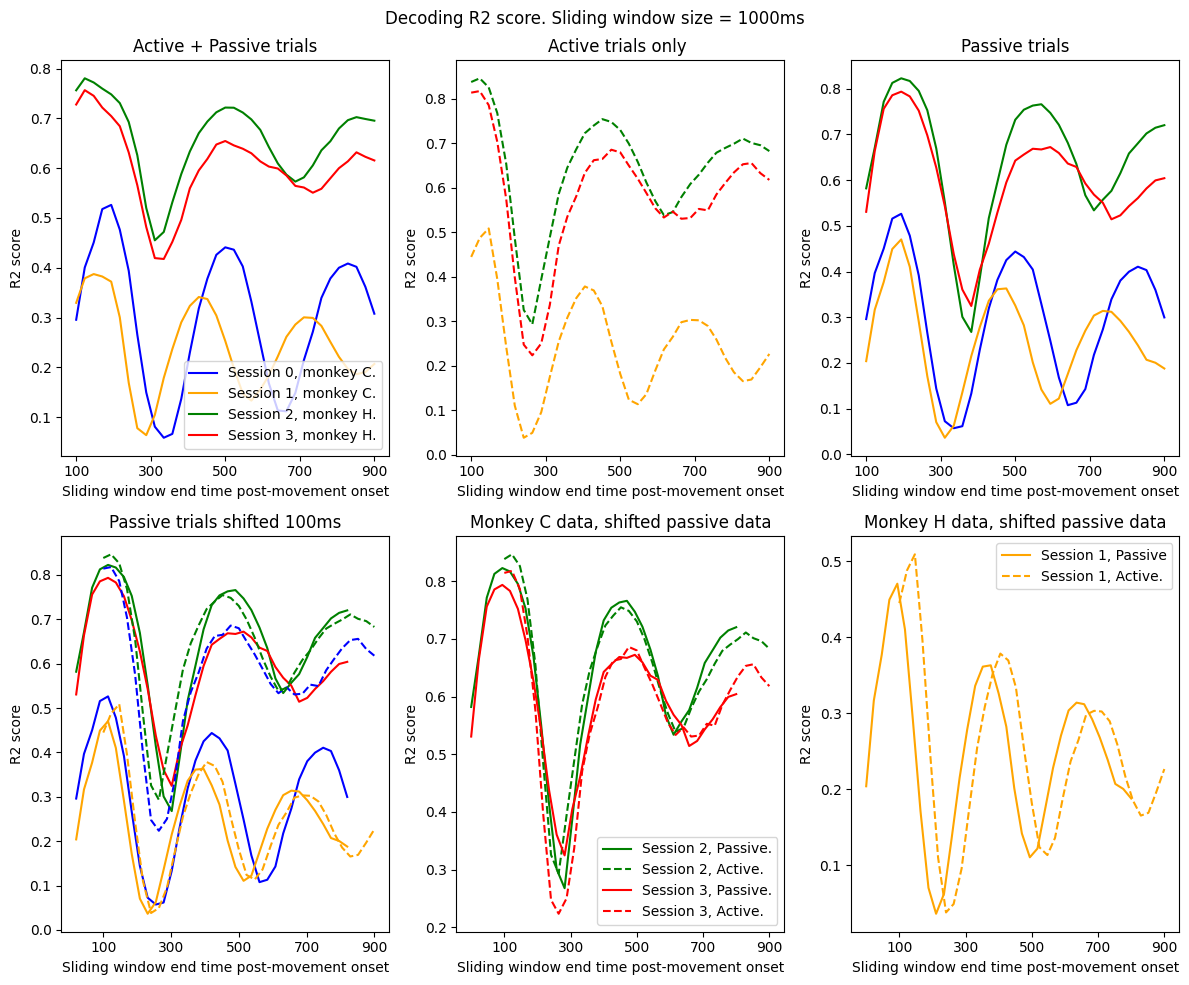

In [266]:
fig, axs = plt.subplots(2, 3, figsize=((12, 10)))
seshcolors = ['blue', 'orange', 'green', 'red']
for x in [0,1,2,3]:
    axs[0, 0].plot(windows, [res[x][0] for res in both_results], color=seshcolors[x], label=f'Session {x}, monkey {"C" if x < 2 else "H"}.')
    axs[0, 2].plot(windows, [res[x][0] for res in pas_results], color=seshcolors[x], label=f'Session {x}, monkey {"C" if x < 2 else "H"}.')
    axs[1, 0].plot(windows-80, [res[x][0] for res in pas_results], color=seshcolors[x], label=f'Session {x}, passive, monkey {"C" if x < 2 else "H"}.')
    
    
for x in [0,1,2]:
    axs[0, 1].plot(windows, [res[x][0] for res in act_results], color=seshcolors[x+1], label=f'Session {x+1}, monkey {"C" if x+1 < 2 else "H"}.', linestyle='--')
    axs[1, 0].plot(windows, [res[x-1][0] for res in act_results], color=seshcolors[x], label=f'Session {x}, active, monkey {"C" if x < 2 else "H"}.', linestyle='--')

for sesh in [2, 3]:
    axs[1, 1].plot(windows-100, [res[sesh][0] for res in pas_results], color=seshcolors[sesh], label=f'Session {sesh}, Passive.')
    axs[1, 1].plot(windows, [res[sesh-1][0] for res in act_results], color=seshcolors[sesh], label=f'Session {sesh}, Active.', linestyle='--')

for sesh in [1]:
    axs[1, 2].plot(windows-100, [res[sesh][0] for res in pas_results], color=seshcolors[sesh], label=f'Session {sesh}, Passive')
    axs[1, 2].plot(windows, [res[sesh-1][0] for res in act_results], color=seshcolors[sesh], label=f'Session {sesh}, Active.', linestyle='--')


for ax in axs.flat:
    ax.set_xlabel('Sliding window end time post-movement onset')
    ax.set_ylabel('R2 score')
    ax.set_xticks([100,300,500,700,900])
axs[0, 0].set_title("Active + Passive trials")
axs[0, 1].set_title("Active trials only ")
axs[0, 2].set_title("Passive trials")
axs[1, 0].set_title("Passive trials shifted 100ms")
axs[1, 1].set_title("Monkey C data, shifted passive data")
axs[1, 2].set_title("Monkey H data, shifted passive data")

axs[0, 0].legend()
#axs[0, 1].legend()
#axs[1, 0].legend()
axs[1, 1].legend(loc='lower right')
fig.suptitle(f"Decoding R2 score. Sliding window size = {window_size*10}ms")
plt.legend()
plt.tight_layout()

plt.show()

# Interesting findings!

It appears that the decoders, when trained on solely active or passive trials, perform exactly the same when the passive trials are shifted about 100ms. This could mean that the decoder has difficulty decoding any shift in position, regardless of whether it is active or passive movement. This makes sense, given the difficulty in decoding with such a small timeframe (150ms) and thus quite little data and context. As we have seen before, the apparent dip during the decoding of 150-300ms post movement onset (PMO) is not really found anywhere in the decoding accuracies found before. There was a dip 150-ms post movement onset for passive trials, which is definitely not apparent here. Need a better comparison.

In [204]:
avg = P_offset_df['idx_goCueTime'] - P_offset_df['idx_movementOnset']
print(P_offset_df.columns)

Index(['trialID', 'monkey', 'task', 'date_time', 'original_bin_size', 'result',
       'bumpDir', 'tgtDir', 'ctrHoldBump', 'ctrHold', 'idx_startTime',
       'idx_endTime', 'idx_bumpTime', 'idx_goCueTime', 'idx_tgtOnTime', 'pos',
       'vel', 'force', 'markers', 'joint_ang', 'joint_vel', 'muscle_len',
       'muscle_vel', 'S1_spikes', 'session', 'bin_size', 'trial_duration',
       'S1_spikes_old', 'acc', 'idx_movementOnset', 'post', 'prior',
       'firing_rates', 'firing_rates_window', 'pos_window', 'vel_window',
       'PCA_window_from_full'],
      dtype='object')


In [205]:
for x in range(0, 20):
    row = P_offset_df.iloc[x]
    if row.result != 'R':
        continue
    print(f'Bumpdir: {row.bumpDir}.  MO: {row.idx_movementOnset}. Targetdir: {row.tgtDir}. goCue: {row.idx_goCueTime}. Diff: {row.idx_goCueTime - row.idx_movementOnset}. Start: {row.idx_startTime}. trialID: {row.trialID}')

Bumpdir: 90.0.  MO: 503. Targetdir: 0.0. goCue: 537. Diff: 34. Start: 303. trialID: 1
Bumpdir: 0.0.  MO: 802. Targetdir: 180.0. goCue: 852. Diff: 50. Start: 640. trialID: 2
Bumpdir: 0.0.  MO: 1118. Targetdir: 0.0. goCue: 1183. Diff: 65. Start: 957. trialID: 3
Bumpdir: 90.0.  MO: 1447. Targetdir: 180.0. goCue: 1483. Diff: 36. Start: 1289. trialID: 4
Bumpdir: 180.0.  MO: 1737. Targetdir: 0.0. goCue: 1779. Diff: 42. Start: 1585. trialID: 5
Bumpdir: 0.0.  MO: 2041. Targetdir: 180.0. goCue: 2107. Diff: 66. Start: 1882. trialID: 6
Bumpdir: 0.0.  MO: 2359. Targetdir: 0.0. goCue: 2402. Diff: 43. Start: 2215. trialID: 7
Bumpdir: 270.0.  MO: 2643. Targetdir: 270.0. goCue: 2705. Diff: 62. Start: 2505. trialID: 8
Bumpdir: 90.0.  MO: 2991. Targetdir: 0.0. goCue: 3048. Diff: 57. Start: 2831. trialID: 9
Bumpdir: 90.0.  MO: 3308. Targetdir: 0.0. goCue: 3348. Diff: 40. Start: 3150. trialID: 10
Bumpdir: 270.0.  MO: 3680. Targetdir: 90.0. goCue: 3738. Diff: 58. Start: 3492. trialID: 11
Bumpdir: 0.0.  MO:

iD: 15. Result: R. Bumpdir: 180.0. Tgtdir: 0.0. Duration: 384


[]

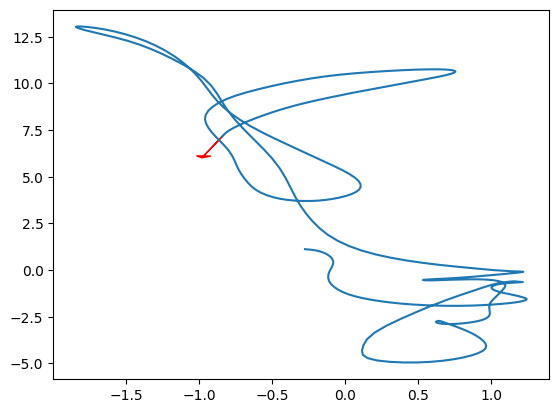

In [214]:
asdf = P_offset_df.iloc[14]
print(f"iD: {asdf.trialID}. Result: {asdf.result}. Bumpdir: {asdf.bumpDir}. Tgtdir: {asdf.tgtDir}. Duration: {asdf.idx_endTime - asdf.idx_startTime}")
x_data = asdf.pos[asdf.prior:asdf.post, 0]
y_data = asdf.pos[asdf.prior:asdf.post, 1]
plt.plot(x_data, y_data)
# Calculate the direction of the last segment

dx = x_data[-1] - x_data[-2]
dy = y_data[-1] - y_data[-2]

# Plot an arrow at the end of the line
plt.arrow(x_data[-2], y_data[-2], dx*10, dy*10, head_width=0.1, head_length=0.1, fc='red', ec='red')

plt.plot()

# I should keep in mind that the average duration of a trial is about 2 seconds, so about 200 bins. Every unit is 10ms. Basically every graph before is useless because I didn't take this into account.

In [273]:
offset = 0
window_size = 15
start = 10
end = 300
amount = 71
windows = np.linspace(start, end, amount).astype(int)
print(windows)
both_results = []
for post in tqdm(windows):
    test = predict_both_pos(data_df = offset_df,
                            model = Ridge(),
                            iterations = 5,
                            prior = 50,
                            post = post,
                            col_to_use = 'PCA_window_from_full',
                            col_to_predict = 'pos_window',
                            time_offset=offset,
                            debug=False,
                            sliding_window = window_size
                            )
    both_results.append(test)
act_results = []
for post in tqdm(windows):
    test = predict_both_pos(data_df = A_offset_df,
                            model = Ridge(),
                            iterations = 5,
                            prior = 50,
                            post = post,
                            col_to_use = 'PCA_window_from_full',
                            col_to_predict = 'pos_window',
                            time_offset=offset,
                            debug=False,
                            sliding_window = window_size
                            )
    act_results.append(test)

pas_results = []
for post in tqdm(windows):
    test = predict_both_pos(data_df = P_offset_df,
                            model = Ridge(),
                            iterations = 5,
                            prior = 50,
                            post = post,
                            col_to_use = 'PCA_window_from_full',
                            col_to_predict = 'pos_window',
                            time_offset=offset,
                            debug=False,
                            sliding_window = window_size
                            )
    pas_results.append(test)

[ 10  14  18  22  26  30  34  39  43  47  51  55  59  63  68  72  76  80
  84  88  92  97 101 105 109 113 117 121 126 130 134 138 142 146 150 155
 159 163 167 171 175 179 184 188 192 196 200 204 208 213 217 221 225 229
 233 237 242 246 250 254 258 262 266 271 275 279 283 287 291 295 300]


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

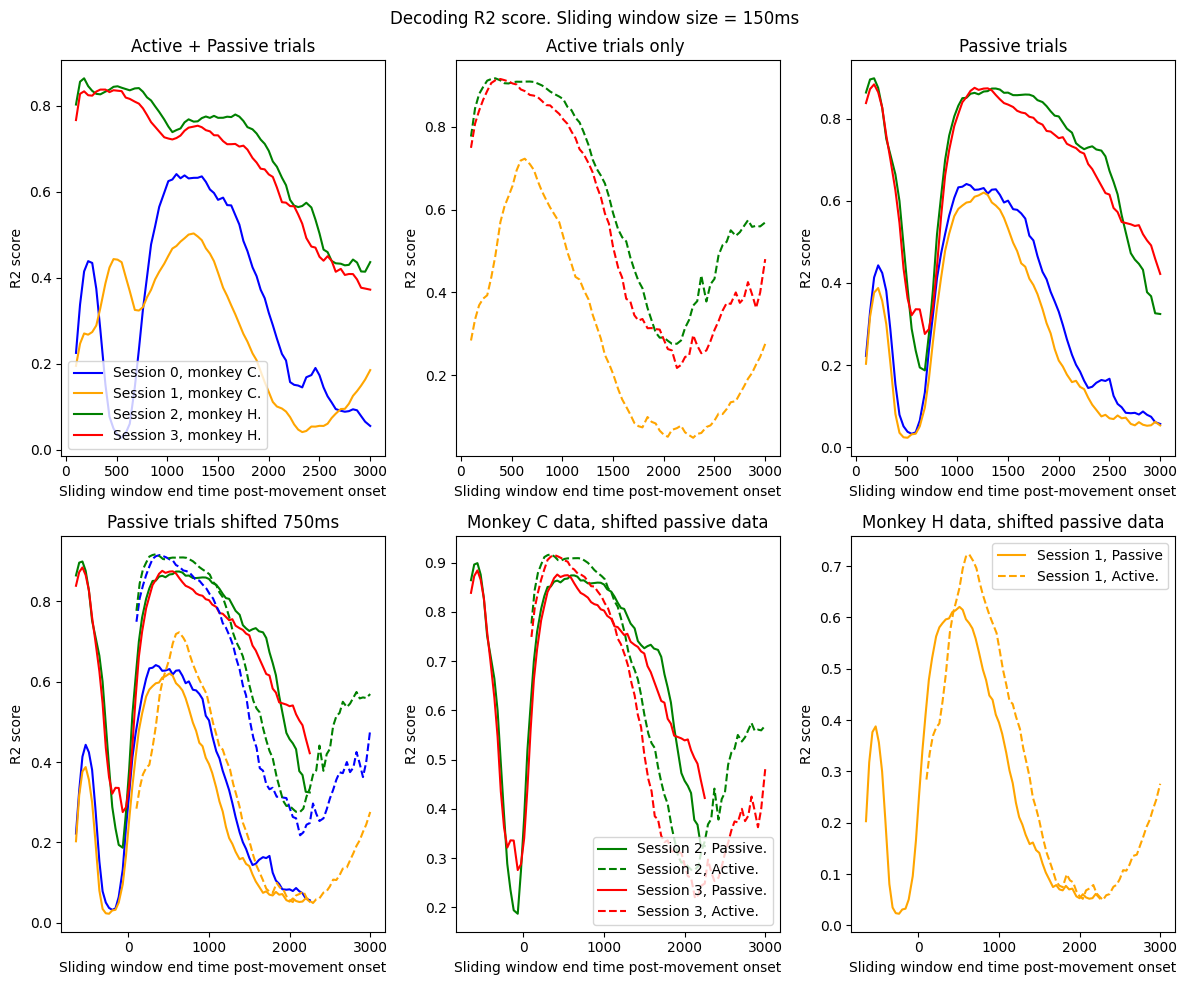

In [277]:
fig, axs = plt.subplots(2, 3, figsize=((12, 10)))
windows_in_ms = windows * 10
shift = 750
seshcolors = ['blue', 'orange', 'green', 'red']
for x in [0,1,2,3]:
    axs[0, 0].plot(windows_in_ms, [res[x][0] for res in both_results], color=seshcolors[x], label=f'Session {x}, monkey {"C" if x < 2 else "H"}.')
    axs[0, 2].plot(windows_in_ms, [res[x][0] for res in pas_results], color=seshcolors[x], label=f'Session {x}, monkey {"C" if x < 2 else "H"}.')
    axs[1, 0].plot(windows_in_ms-shift, [res[x][0] for res in pas_results], color=seshcolors[x], label=f'Session {x}, passive, monkey {"C" if x < 2 else "H"}.')
    
    
for x in [0,1,2]:
    axs[0, 1].plot(windows_in_ms, [res[x][0] for res in act_results], color=seshcolors[x+1], label=f'Session {x+1}, monkey {"C" if x+1 < 2 else "H"}.', linestyle='--')
    axs[1, 0].plot(windows_in_ms, [res[x-1][0] for res in act_results], color=seshcolors[x], label=f'Session {x}, active, monkey {"C" if x < 2 else "H"}.', linestyle='--')

for sesh in [2, 3]:
    axs[1, 1].plot(windows_in_ms-shift, [res[sesh][0] for res in pas_results], color=seshcolors[sesh], label=f'Session {sesh}, Passive.')
    axs[1, 1].plot(windows_in_ms, [res[sesh-1][0] for res in act_results], color=seshcolors[sesh], label=f'Session {sesh}, Active.', linestyle='--')

for sesh in [1]:
    axs[1, 2].plot(windows_in_ms-shift, [res[sesh][0] for res in pas_results], color=seshcolors[sesh], label=f'Session {sesh}, Passive')
    axs[1, 2].plot(windows_in_ms, [res[sesh-1][0] for res in act_results], color=seshcolors[sesh], label=f'Session {sesh}, Active.', linestyle='--')


for ax in axs.flat:
    ax.set_xlabel('Sliding window end time post-movement onset')
    ax.set_ylabel('R2 score')
#    ax.set_xticks([100,300,500,700,900])
axs[0, 0].set_title("Active + Passive trials")
axs[0, 1].set_title("Active trials only ")
axs[0, 2].set_title("Passive trials")
axs[1, 0].set_title(f"Passive trials shifted {shift}ms")
axs[1, 1].set_title("Monkey C data, shifted passive data")
axs[1, 2].set_title("Monkey H data, shifted passive data")

axs[0, 0].legend()
#axs[0, 1].legend()
#axs[1, 0].legend()
axs[1, 1].legend(loc='lower right')
fig.suptitle(f"Decoding R2 score. Sliding window size = {window_size*10}ms")
plt.legend()
plt.tight_layout()

plt.show()

In [268]:
A_average_duration = round(np.mean(A_offset_df['idx_endTime'] - A_offset_df['idx_startTime']), 3)
P_average_duration = round(np.mean(P_offset_df['idx_endTime'] - P_offset_df['idx_startTime']), 3)
P_diff_cue_mo = round(np.mean(P_offset_df['idx_goCueTime'] - P_offset_df['idx_movementOnset']))
print(f"Active avg. duration: {A_average_duration}. Passive avg. duration: {P_average_duration}. Average difference between movement Cue Movement Onset: {P_diff_cue_mo*10}")

Active avg. duration: 190.601. Passive avg. duration: 277.939. Average difference between movement Cue Movement Onset: 650


# Final thought Tuesday

- I really have to watch out for the ms thing. Each bin is 10 ms, and I'm taking that into account properly only now. Maybe re-make some graphs.

- Decoding active vs. passive seems to go according to expectations.
    - In the case of active trials, decoding seems to be optimal, but goes down after a while.
    - In the case of passive trials, it appears that the passive movement really throws decoders off, and decoding accuracy is very low. After this though, accuracy appears to go to heights equal to that of active accuracy. 
    - Offsetting passive trials by the *average difference between cue & movement onset* + *guessed reaction time*, gives similar decoding windows. This is extremely visible in graph 5 and 6, once again indicating that the principal components used by the decoder also encoded the intention to move.
    - The curves are very similar. Is there a measure that I could use to indicate this similarity?